In [1]:
suppressPackageStartupMessages({

library(GenomicRanges)
library(rtracklayer)
library(VariantAnnotation)
library(tidyverse)
library(glue)
library(here)
    
devtools::load_all(".")
})

Loading ychr


In [2]:
get_lengths <- function(bam) { 
    lengths <- paste("samtools view ", bam, " | cut -f10 | awk '{print length($0)}'") %>%
        pipe %>%
        scan
    name <- basename(bam) %>% str_replace_all("^[a-z]+_|.bam$", "")
    regions <- basename(bam) %>% str_replace_all("^([a-z]+)_.*", "\\1")
    
    tibble(name = name, regions = regions, length = lengths)
}

In [3]:
length_df <-
    list.files(here("data/bam"), "full_.*.bam$", full.names = TRUE) %>%
    str_subset("control", negate = TRUE) %>%
    map_dfr(get_lengths) %>%
    mutate(set = case_when(
        name %in% c("spy1", "mez2", "elsidron1", "elsidron2", "den8", "den4") ~ "capture",
        name %in% c("ustishim") ~ "shotgun_ancient",
        TRUE ~ "shotgun_modern"
    ))

In [5]:
length_df %>%
group_by(name, regions, set) %>%
summarise(length = mean(length)) %>%
spread(regions, length) %>%
arrange(full)

name,set,full
den8,capture,44.77619
spy1,capture,51.18383
den4,capture,53.89470
mez2,capture,54.09177
ustishim,shotgun_ancient,61.25364
a00,shotgun_modern,99.21773
S_Han-2,shotgun_modern,99.96235
S_Mandenka-1,shotgun_modern,99.96451
S_French-1,shotgun_modern,99.97098
S_Mbuti-1,shotgun_modern,99.97672


In [9]:
length_df %>%
group_by(name, regions, set) %>%
summarise(length = mean(length)) %>% head

name,regions,set,length
a00,full,shotgun_modern,99.21773
den4,full,capture,53.89470
den8,full,capture,44.77619
mez2,full,capture,54.09177
S_BedouinB-1,full,shotgun_modern,99.98860
S_Burmese-1,full,shotgun_modern,99.98854


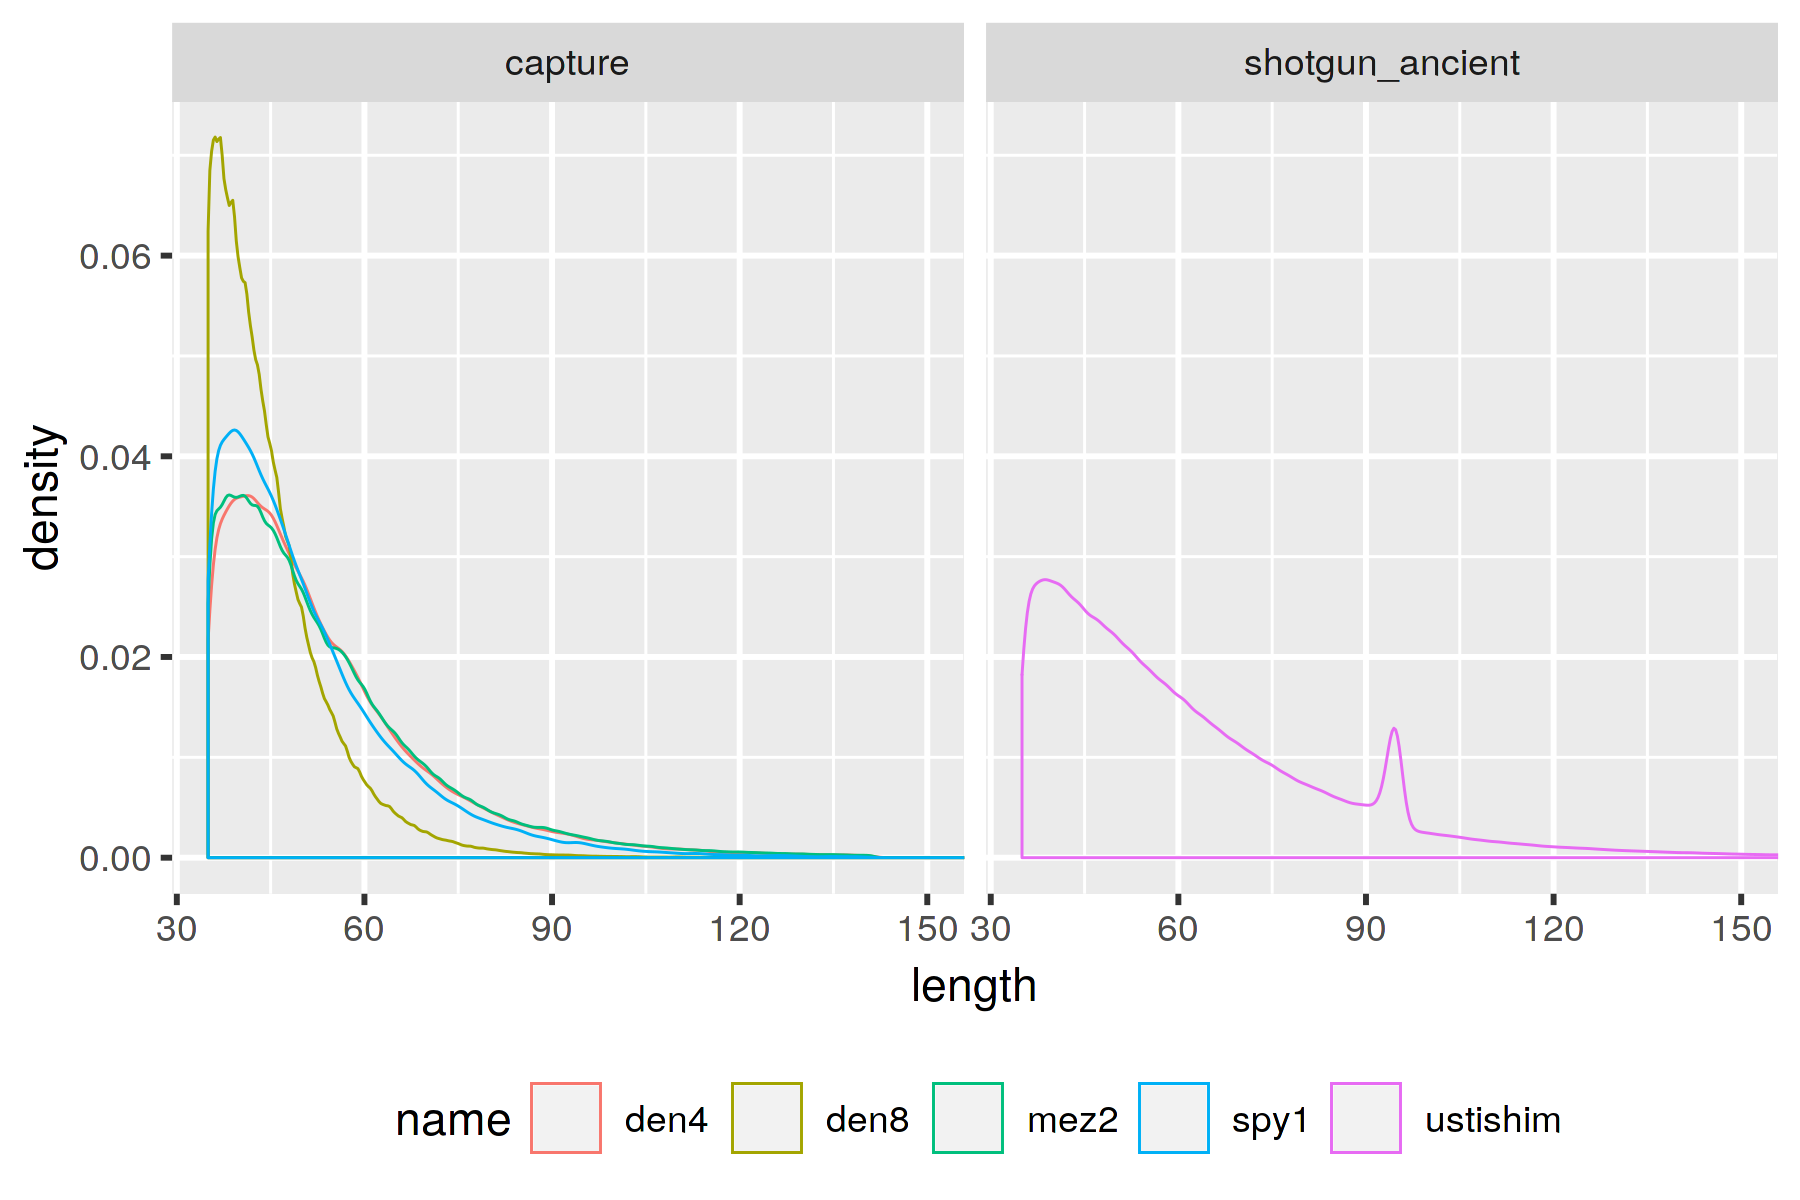

In [11]:
set_dim(6, 4, 300)

filter(length_df, regions == "full", set != "shotgun_modern") %>%
ggplot(aes(length, color = name)) +
    geom_density(size = 0.25) +
    facet_wrap(~ set) +
    coord_cartesian(x = c(35, 150)) +
    theme(legend.position = "bottom")

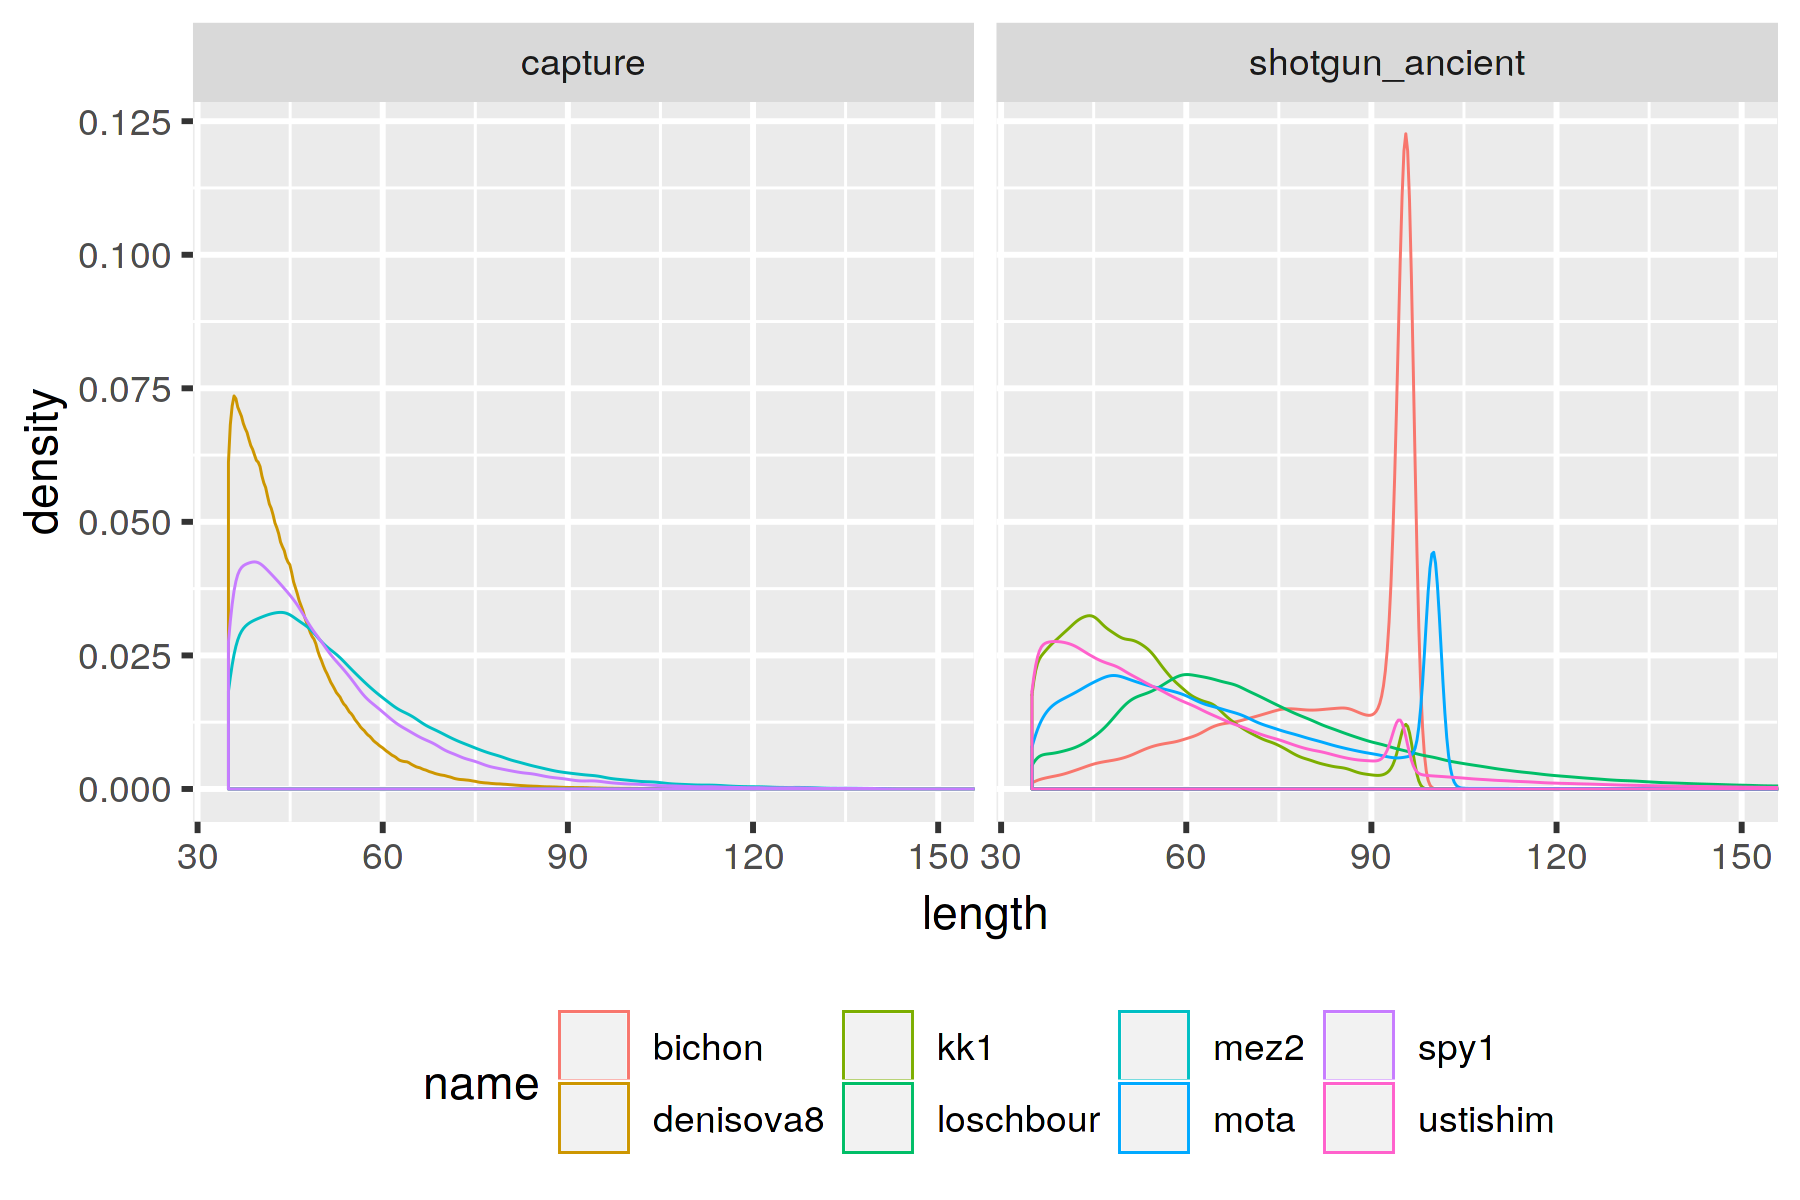

In [28]:
set_dim(6, 4, 300)

filter(length_df, regions == "full", set != "shotgun_modern") %>%
ggplot(aes(length, color = name)) +
    geom_density(size = 0.25) +
    facet_wrap(~ set) +
    coord_cartesian(x = c(35, 150)) +
    theme(legend.position = "bottom")